# _Imports_, constantes e funções de classificação

In [181]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import svm, tree, ensemble, neighbors, preprocessing

DATASET_NAME = 'dataset.csv'
TEST_SIZE = 0.7
FOLDS_COUNT = 5
MAX_DEPTH = 15
np.random.seed(1000)

class DataSet:
    def __init__(self, ignoreColumns):
        self.df = (pd.read_csv(DATASET_NAME)).drop(columns=ignoreColumns)
        
        self.target = (self.df['koi_disposition'] == 'CONFIRMED').astype(int)
        self.df = self.df.drop(columns=['koi_disposition'])
        
        self.features = self.df.shape[1]
                
        self.df = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(self.df.values))
        
        msk = np.random.rand(len(self.df)) < TEST_SIZE
        self.trainDf = self.df[msk]
        self.trainTarget = self.target[msk]
        
def naiveBayesClassifier(df, output):
    return (cross_val_score(GaussianNB(), df, output, cv=FOLDS_COUNT)).mean()

def decisionTreeClassifier(df, output, maxDepth):
    clf = tree.DecisionTreeClassifier(max_depth=maxDepth)
    return (cross_val_score(clf, df, output, cv=FOLDS_COUNT)).mean()
    
def randomForestClassifier(df, output, trainExamples, trainLabels, features, maxDepth):
    clf = ensemble.RandomForestClassifier(n_estimators=features, max_depth=maxDepth)
    clf = clf.fit(trainExamples, trainLabels)
    return (cross_val_score(clf, df, output, cv=FOLDS_COUNT)).mean()

def adaboostClassifier(df, output, trainExamples, trainLabels, estimatorsCount):
    clf = ensemble.AdaBoostClassifier(n_estimators=estimatorsCount)
    clf = clf.fit(trainExamples, trainLabels)
    return (cross_val_score(clf, df, output, cv=FOLDS_COUNT)).mean()

def knnClassifier(df, output, trainExamples, trainLabels, k):
    clf = (neighbors.KNeighborsClassifier(n_neighbors=k)).fit(trainExamples, trainLabels)
    return (cross_val_score(clf, df, output, cv=FOLDS_COUNT)).mean()
    
def svmLinearClassifier(df, output, trainExamples, trainLabels, C):
    clf = (svm.SVC(C, kernel='linear', gamma='auto')).fit(trainExamples, trainLabels)
    return (cross_val_score(clf, df, output, cv=FOLDS_COUNT)).mean()

def svmRbfClassifier(df, output, trainExamples, trainLabels, C):
    clf = (svm.SVC(C, kernel='rbf', gamma='auto')).fit(trainExamples, trainLabels)
    return (cross_val_score(clf, df, output, cv=FOLDS_COUNT)).mean()

def svmSigmoidClassifier(df, output, trainExamples, trainLabels, C):
    clf = (svm.SVC(C, kernel='sigmoid', gamma='auto')).fit(trainExamples, trainLabels)
    return (cross_val_score(clf, df, output, cv=FOLDS_COUNT)).mean()

def svmPolyClassifier(df, output, trainExamples, trainLabels, C):
    clf = (svm.SVC(C, kernel='poly', gamma='auto')).fit(trainExamples, trainLabels)
    return (cross_val_score(clf, df, output, cv=FOLDS_COUNT)).mean()

# Funções para visualização dos dados

In [182]:
def showDecisionTreeStats(maxDepth):
    decisionTreeScores = [0]
    for i in range(1,maxDepth+1):
        decisionTreeScores.append(decisionTreeClassifier(ds.df, ds.target, i))

    gs = gridspec.GridSpec(1, 1, figure=plt.figure(num=None, figsize=(8, 5)))
    ax = plt.subplot(gs[0])
    ax.title.set_text('Acurácia de acordo com o aumento da altura da arvore')
    ax.grid(True)
    ax.set_xlabel('Altura')
    ax.set_ylabel('Acurácia')
    ax.set_xlim([1, maxDepth])
    ax.set_ylim([0.7, 1])
    ax.plot(np.array([score for score in decisionTreeScores]), label="Decision Tree")
    ax.plot(np.array([naiveBayesMeanScore for i in range(0, len(decisionTreeScores))]), label="Naive Bayes")
    ax.legend()
    plt.show()
    
def showRandomForestStats(maxDepth):
    randomForestUnlimtdDepthScores = [0]
    for i in range(1,ds.features + 1):
        randomForestUnlimtdDepthScores.append(randomForestClassifier(ds.df, ds.target, ds.trainDf, ds.trainTarget, i, None))

    randomForestDepthByFeaturesScores = {}
    for i in range(1, maxDepth + 1):
        randomForestDepthByFeaturesScores[i] = [0]
        for j in range(1, ds.features + 1):
            randomForestDepthByFeaturesScores[i].append(randomForestClassifier(ds.df, ds.target, ds.trainDf, ds.trainTarget, j, i))

    gs = gridspec.GridSpec(4, 1, figure=plt.figure(num=None, figsize=(16, 22)), height_ratios=[3,8,8,8])
    ax1 = plt.subplot(gs[0])
    ax1.title.set_text('Acurácia com altura ilimitada x aumento de features')
    ax1.set_xlabel('Features')
    ax1.set_ylabel('Acurácia')
    ax1.set_xlim([1, ds.features])
    ax1.set_yticks([0.91, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98])
    ax1.set_ylim([0.91, 0.98])
    ax1.plot(np.array([score for score in randomForestUnlimtdDepthScores]), label="Random Forest")
    ax1.plot(np.array([naiveBayesMeanScore for i in range(0, len(randomForestUnlimtdDepthScores))]), label="Naive Bayes")
    ax1.legend()
    ax1.grid(True)

    ax2 = plt.subplot(gs[1])
    ax2.title.set_text('Acurácia da altura (de 1 a 5) x aumento de features')
    ax2.set_xlabel('Features')
    ax2.set_ylabel('Acurácia')
    ax2.set_xlim([1, ds.features])
    ax2.set_ylim([0.67, 0.98])
    for j in range(1, 6):
        ax2.plot(np.array([score for score in randomForestDepthByFeaturesScores[j]]), label="RF Depth={}".format(j))
    ax2.plot(np.array([naiveBayesMeanScore for j in range(0, len(randomForestUnlimtdDepthScores))]), label="Naive Bayes")
    ax2.legend()
    ax2.grid(True)

    ax3 = plt.subplot(gs[2])
    ax3.title.set_text('Acurácia da altura (de 6 a 10) x aumento de features')
    ax3.set_xlabel('Features')
    ax3.set_ylabel('Acurácia')
    ax3.set_xlim([1, ds.features])
    ax3.set_ylim([0.905, 0.97])
    for j in range(6, 11):
        ax3.plot(np.array([score for score in randomForestDepthByFeaturesScores[j]]), label="RF Depth={}".format(j))
    ax3.plot(np.array([naiveBayesMeanScore for j in range(0, len(randomForestUnlimtdDepthScores))]), label="Naive Bayes")
    ax3.legend()
    ax3.grid(True)

    ax4 = plt.subplot(gs[3])
    ax4.title.set_text('Acurácia da altura (de 11 a 15) x aumento de features')
    ax4.set_xlabel('Features')
    ax4.set_ylabel('Acurácia')
    ax4.set_xlim([1, ds.features])
    ax4.set_ylim([0.91, 0.97])
    for j in range(11, 15):
        ax4.plot(np.array([score for score in randomForestDepthByFeaturesScores[j]]), label="RF Depth={}".format(j))
    ax4.plot(np.array([naiveBayesMeanScore for j in range(0, len(randomForestUnlimtdDepthScores))]), label="Naive Bayes")
    ax4.legend()
    ax4.grid(True)

    plt.subplots_adjust(hspace=0.25)
    plt.show()
    
def showAdaboostStats():
    adaboostScores = [0]
    for i in range(1, ds.features + 1):
        adaboostScores.append(adaboostClassifier(ds.df, ds.target, ds.trainDf, ds.trainTarget, i))

    gs = gridspec.GridSpec(1, 1, figure=plt.figure(num=None, figsize=(8, 5)))
    ax = plt.subplot(gs[0])
    ax.title.set_text('Acurácia de acordo com o aumento features')
    ax.grid(True)
    ax.set_xlabel('Features')
    ax.set_ylabel('Acurácia')
    ax.set_xlim([1, ds.features + 1])
    ax.set_ylim([0.7, 1])
    ax.plot(np.array([score for score in adaboostScores]), label="Adaboost")
    ax.plot(np.array([naiveBayesMeanScore for i in range(0, len(adaboostScores))]), label="Naive Bayes")
    ax.legend()
    plt.show()
    
def showKnnStats(kValues):
    knnScores = {}

    for i in range(0,len(kValues)):
        knnScores[kValues[i]] = knnClassifier(ds.df, ds.target, ds.trainDf, ds.trainTarget, kValues[i])

    fig, ax = plt.subplots(figsize=(8,8))
    sns.lineplot(x=kValues, y=[v for k,v in knnScores.items()], color='r', ax=ax)
    sns.lineplot(x=kValues, y=[naiveBayesMeanScore for i in knnScores.items()], color='b', ax=ax)    
    ax.legend(['KNN', 'Naive Bayes'], facecolor='w')
    plt.xticks(kValues)
    plt.xlim([0.5, 29.5])
    plt.grid(True)
    plt.show()
    
def showSvmStats():
    penalties = [1,2,3,4,5,6,7,8,9,10]
    svmScores = {}

    svmScores['linear'] = [0]
    svmScores['rbf'] = [0]
    svmScores['sigmoid'] = [0]
    svmScores['poly'] = [0]

    for i in penalties:
        svmScores['linear'].append(svmLinearClassifier(ds.df, ds.target, ds.trainDf, ds.trainTarget, i))
        svmScores['rbf'].append(svmRbfClassifier(ds.df, ds.target, ds.trainDf, ds.trainTarget, i))
        svmScores['sigmoid'].append(svmSigmoidClassifier(ds.df, ds.target, ds.trainDf, ds.trainTarget, i))
        svmScores['poly'].append(svmPolyClassifier(ds.df, ds.target, ds.trainDf, ds.trainTarget, i))

    gs = gridspec.GridSpec(1, 1, figure=plt.figure(num=None, figsize=(8, 5)))
    ax = plt.subplot(gs[0])
    ax.title.set_text('Acurácia de acordo com o aumento penalidade')
    ax.grid(True)
    ax.set_xlabel('Penalidade')
    ax.set_ylabel('Acurácia')
    ax.set_xticks(penalties)
    ax.set_xlim([0.9, 10.1])
    ax.set_ylim([0.55, 0.95])
    ax.plot(np.array([score for score in svmScores['linear']]), label="Linear")
    ax.plot(np.array([score for score in svmScores['rbf']]), label="RBF")
    ax.plot(np.array([score for score in svmScores['sigmoid']]), label="Sigmoid")
    ax.plot(np.array([score for score in svmScores['poly']]), label="Polynomial")
    ax.plot(np.array([naiveBayesMeanScore for i in range(0, (len(penalties) +1))]), label="Naive Bayes")
    ax.legend()
    plt.show()
    
def showConfusionMatrix():
    cm = metrics.confusion_matrix(y_val, y_pred)

    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title="Matriz de Confusão",
           ylabel="Real",
           xlabel="Predito")

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max()/2. else "black")
    fig.tight_layout()
    plt.show()

# Instanciar DataSet, e gerar score para _Naive Bayes_

In [184]:
ds = DataSet(['kepoi_name'])
naiveBayesMeanScore = naiveBayesClassifier(ds.df, ds.target)

# Decision Tree
Avaliação da acurácia do modelo utilizando _Decision Tree_, em comparação com o _Naive Bayes_

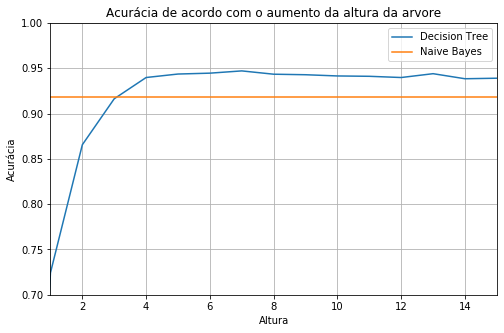

In [185]:
showDecisionTreeStats(MAX_DEPTH)

Podemos ver o aumento da acurácia do modelo de acordo com o aumento da altura da árvore; É notável o aumento no início do gráfico, mostrando o quão ineficaz é esse modelo com uma altura pequena.<br>
A acurácia do modelo com a altura da árvore não sendo definida (ou seja, o algoritmo adicionando _nodos_ na árvore até que todos os dados estejam separados) é vista acima do gráfico. Podemos ver que esse valor (_0.939_) é __menor__ do que o __maior__ presente no gráfico (próximo de _0.95_); Isso mostra que a adição de _nodos_ na árvore a tornou específica demais, causando _overfitting_; o próprio gráfico mostra isso: O __maior__ valor da acurácia é na linha de _0.95_, e após esse máximo ele tende a se estabilizar um pouco abaixo dessa linha, muito próximo de onde o valor para quantidade indefinida de _nodos_ provavelmente estaria.

# Random Forest
Avaliação do modelo utilizando _Random Forest_, em comparação com o _Naive Bayes_
<br>_(execução demorada)_

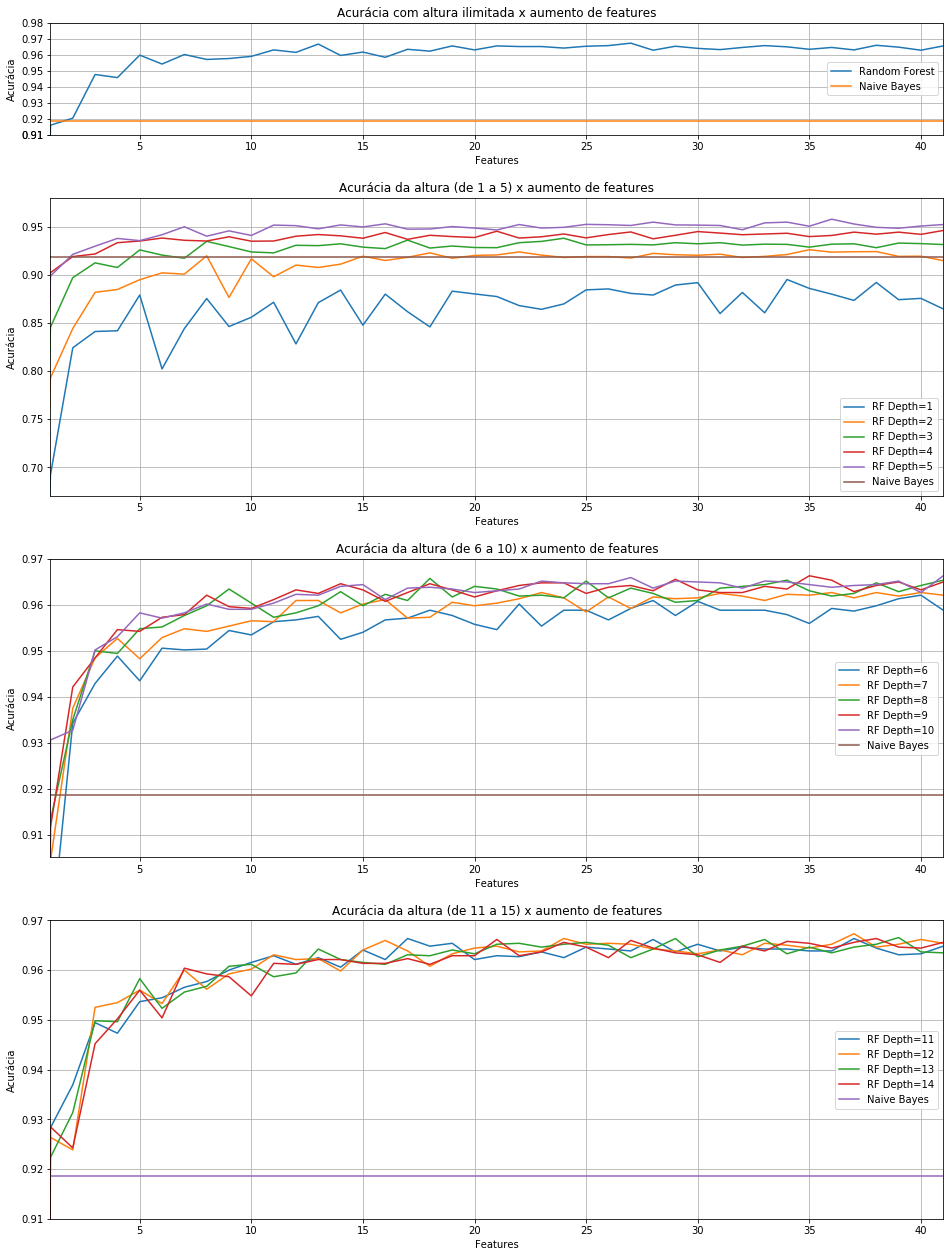

In [186]:
showRandomForestStats(MAX_DEPTH)

Podemos analisar algumas variações na eficiência uma vez que deixamos de utilizar somente uma _Decision Tree_ (experimento anterior) e passamos a utilizar várias utilizando _bagging_ e setando o número de _features_ utilizadas para montar cada uma das várias árvores: O melhor valor para a altura da árvore encontrado no experimento anterior não é mais tão eficiente; isso mostra que para quantidades de features diferentes utilizadas como parâmetros da árvore, diferentes alturas se tornam o melhor o caso.<br>Outro ponto interessante é que o desempenho dos modelos utilizando árvores em que o tamanho não é definido (ou seja, a árvore cresce até que todos os dados estejam separados) passa a ser uma boa opção; o algoritmo agora tendo um número de _features_ definido, trabalha melhor com uma árvore sem limite de tamanho. Podemos dizer que o desempenho do algorítmo _Random Forest_ para este dataset é igualmente eficiente tanto para altura ilimitada quanto para as maiores alturas iguais. Por outro lado, o desempenho utilizando alturas menores ou iguais à 6 tem considerável piora ao definir uma quantidade fixa de _features_, apesar de ganharem acurácia à medida que a quantidade de _features_ aumenta (o que faz sentido: as árvores se tornam pouco capazes de separar os dados de forma eficiente com uma altura limitada __e__ terem poucas _features_ à se utilizar, vão ganhando eficiência ao aumentar a quantidade de _features_ mas continuam com desempenho pior se comparadas à árvores com alturas maiores e mesma quantidade de _features_).

# Gradient Boost Tree
Avaliação do modelo utilizando _Gradient Boost Tree_, em comparação com o _Naive Bayes_

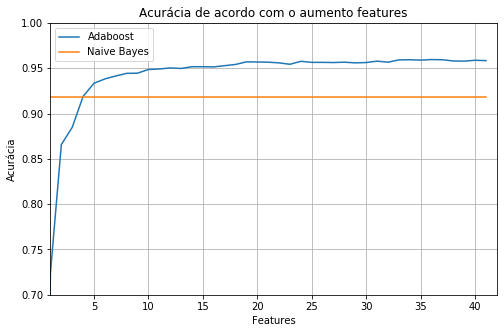

In [187]:
showAdaboostStats()

Assim como os demais modelos que utilizam _Decision Tree_'s que foram testados anteriormente, o _AdaBoost_ também supera o desempenho do _Naive Bayes_ uma vez que já tem uma quantidade mínima de _features_ dos dados a utilizar se utilizar. O gráfico mostra que, mesmo com a heurística do algorítmo (ajuste do modelo de acordo com os erros do modelo anterior), uma quantidade pequena de _features_ a se utilizar evita uma eficiência satisfatória.

# KNN
Avaliação da acurácia do modelo utilizando _KNN_, em comparação com o _Naive Bayes_.

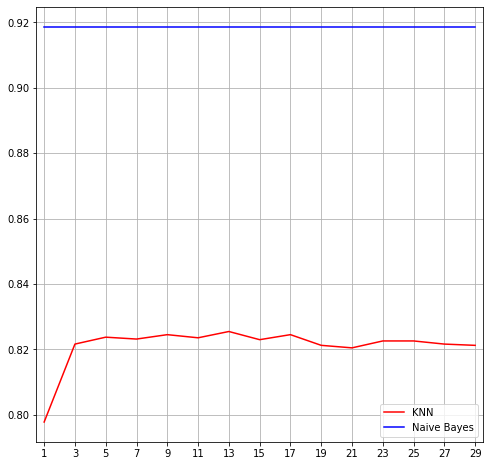

In [188]:
showKnnStats([1,3,5,7,9,11,13,15,17,19,21,23,25,27,29])

O gráfico mostra que eficiência do _Naive Bayes_ supera a do _KNN_, e isso faz sentido, pois _Naive Bayes_ é um modelo não paramétrico, e portanto, funciona bem com menos dados.<br>Outro dado mostrado pelo gráfico é a queda de eficiência ao utilizar K = 1; ao levar em conta somente o primeiro vizinho mais próximo o algorítmo possivelmente irá errar algumas vezes por levar em conta somente um ruido, situação que é mitigada ao utilizar uma quantidade maior de vizinhos para análise.

# SVM
Análise da acurácia do modelo utilizando _Support Vector Machine_, em comparação com o _Naive Bayes_.

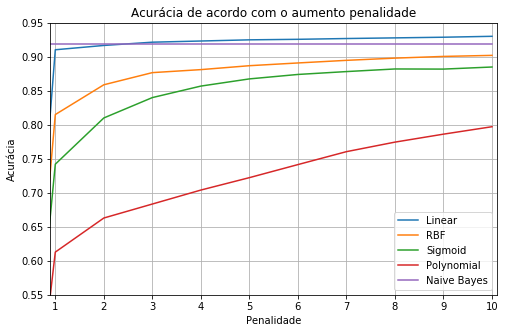

In [189]:
showSvmStats()

Conforme o gráfico, vemos que que o _SVM Linear_ é mais eficiente que o _Naive Bayes_, enquanto os demais não conseguem superá-lo mesmo com o aumento da acurácia que acompanha o aumento da penalidade.<br>Outro dado interessante é o aumento da acurácia em todos os modelos de _SVM_ à medida que se aumenta a penalidade imposta ao modelo; isso mostra que provavelmente esse modelo possui muitos _outliers_, sendo então necessário impor uma maior penalidade ao modelo em caso de classificação erradas.